# OrderGenie with LangGraph and the Gemini API

In this notebook, you will use [LangGraph](https://www.langchain.com/langgraph) to define a stateful graph-based application built on top of the Gemini API.

You will build a simulated retail User Account Management system, called OrderGenie. It will provide a looping chat interface to customers where they can query about order history and order status and also make order cancellations and initiate returns

OrderGenie is used in other Gemini API demos, so if you are looking to explore something with a more minimal implementation, check out the [EcomAccountBot function calling example]() that implements a similar system using only the Gemini API Python SDK and function calling.

# Building a Gemini Langgraph AI Agent: A Comprehensive Guide
In the ever-evolving world of AI-driven solutions, integrating diverse capabilities of generative AI into a cohesive system can significantly enhance functionality and user experience. This guide explores the development of a Gemini Langgraph-based AI agent, designed to manage and process customer orders with advanced AI features such as structured output, few-shot prompting, grounding, and more. Let's embark on the journey of building this intelligent assistant.

# Introduction to the AI Agent
        Our AI agent, OrderGenie, serves as an interactive chatbot that helps users manage their orders by interfacing with a SQL database. Using LangGraph and Gemini, the agent efficiently interacts with users, providing purchase histories, managing returns, and handling cancellations—all while ensuring data privacy and accuracy.

# Key AI Capabilities Integrated
        * Structured Output:
            Description: The agent utilizes structured output to perform specific functions, such as invoking database query tools via predefined interfaces.
             Significance: This enhances clarity and consistency in the user's interaction with the AI, ensuring that the output is predictable and well-organized, especially when displaying order details or transaction summaries.
        * Function Calling:
            Description: By leveraging decorated Python functions, the agent invokes precise operations like listing tables, describing schemas, and executing queries.
             Significance: Function calling modularizes the operations, ensuring dependable interactions with the database. This abstraction allows the AI to handle complex tasks efficiently while presenting a simple interface to the user.
        * Controlled Generation:
            Description: The AI is trained to follow given instructions, keeping conversations focused and directed toward specific outcomes, like querying order details.
            Significance: Controlled generation maintains the relevance and coherence of interactions, which is crucial for professional and accurate customer service engagements, preventing deviations into unrelated topics.
        * Agents:
            Description: OrderGenie functions as a self-contained agent, autonomously managing conversation flow and task execution without needing external prompts.
            Significance: This autonomy enables the AI to streamline operations by handling routine tasks, reducing the need for human oversight and increasing service scalability.
        * Few-shot Prompting:
            Description: The agent is guided using a few examples included in the instructions, showing typical user interactions to guide response generation.
            Significance: Few-shot prompting equips the AI with the ability to respond appropriately to similar scenarios, enhancing its adaptability and accuracy even when encountering limited data.
        * Grounding:
             Description: The AI ensures its responses are based on factual data from the database, validating information before presenting it to the user.
            Significance: Grounding enhances the credibility of responses by tying them to verifiable data, reducing errors, and building user trust.

## **IMPORTANT!**

The app built in this notebook takes **user input** using a **text box** ([Python's `input`](https://docs.python.org/3/library/functions.html#input)). These are commented-out to ensure that you can use the `Run all` feature without interruption. Keep an eye out for the steps where you need to uncomment the `.invoke(...)` calls in order to interact with the app.

If you wish to save a version of this notebook with `Save and Run all`, you will need to **re-comment** the lines you commented-out to ensure that the notebook can run without human input.

## Get set up

Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [175]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip uninstall -qqy jupyterlab 
!pip install -U -q "google-genai==1.7.0"

In [176]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Automated retry for genai APIs

In [177]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

The `GOOGLE_API_KEY` environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph. 

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [178]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## Create a local database

For this minimal example, you'll create a local SQLite database and add some synthetic data so you have something to query.

Load the `sql` IPython extension so you can interact with the database using magic commands (the `%` instructions) to create a new, empty SQLite database.

Create the tables and insert some synthetic data. Feel free to tweak this structure and data.

In [179]:
%load_ext sql
%sql sqlite:///sample.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [180]:
%%sql
-- Create the ' ORDER_ITEM_FULFILLMENT_RECORD ' table
    
CREATE TABLE ORDER_ITEM_FULFILLMENT_RECORD (
  ORDER_FG_ITEM_TRANSACTION_ID  INTEGER          NOT NULL,
  EMAIL_ID                     TEXT             NOT NULL,
  ORDER_ID                     TEXT             NOT NULL,
  ORDER_DATE                   TEXT             NOT NULL, 
  FG_ID                        INTEGER          NOT NULL,
  FULFILLMENT_METHOD           TEXT             NOT NULL,
  FULFILLMENT_ID               INTEGER          NOT NULL,
  EVENT_TYPE                   TEXT             NOT NULL,
  PRODUCT_SKU                  TEXT             NOT NULL,
  QUANTITY                     INTEGER          NOT NULL,
  SALE_AMOUNT                  REAL             NOT NULL,
  REGISTER_PRICE               REAL,
  RETAIL_PRICE                 REAL,
  TAX_APPLICABLE               INTEGER,
  LINE_ITEM_NOTE               TEXT,
  EXTERNAL_SYSTEM_ID           TEXT,
  CREATED_AT                   TEXT             NOT NULL,
  ORIGINAL_FULFILLMENT_ID      INTEGER
);

-- Create the 'ORDER_TRACKING' table
CREATE TABLE IF NOT EXISTS ORDER_TRACKING (
    ORDER_ID TEXT NOT NULL,
    ORDER_DATE TEXT NOT NULL, -- Use TEXT for ISO-8601 format or INTEGER for Unix timestamp
    TRACKING_URL TEXT NOT NULL
);

-- Insert data into the 'ORDER_TRACKING' table
INSERT INTO ORDER_TRACKING (ORDER_ID, ORDER_DATE, TRACKING_URL) VALUES
('ORD001', '2023-10-01', 'http://tracking.example.com/track?id=ORD001'),
('ORD002', '2023-09-28', 'http://tracking.example.com/track?id=ORD002'),
('ORD003', '2023-09-15', 'http://tracking.example.com/track?id=ORD003'),
('ORD004', '2023-09-22', 'http://tracking.example.com/track?id=ORD004'),
('ORD005', '2023-09-29', 'http://tracking.example.com/track?id=ORD005'),
('ORD006', '2023-10-02', 'http://tracking.example.com/track?id=ORD006'),
('ORD007', '2023-09-30', 'http://tracking.example.com/track?id=ORD007'),
('ORD008', '2023-09-18', 'http://tracking.example.com/track?id=ORD008'),
('ORD009', '2023-09-25', 'http://tracking.example.com/track?id=ORD009'),
('ORD010', '2023-10-03', 'http://tracking.example.com/track?id=ORD010');

-- Insert data into the 'ORDER_ITEM_FULFILLMENT_RECORD' table
INSERT INTO ORDER_ITEM_FULFILLMENT_RECORD (
  ORDER_FG_ITEM_TRANSACTION_ID,
  EMAIL_ID,
  ORDER_ID,
  ORDER_DATE,
  FG_ID,
  FULFILLMENT_METHOD,
  FULFILLMENT_ID,
  EVENT_TYPE,
  PRODUCT_SKU,
  QUANTITY,
  SALE_AMOUNT,
  REGISTER_PRICE,
  RETAIL_PRICE,
  TAX_APPLICABLE,
  LINE_ITEM_NOTE,
  EXTERNAL_SYSTEM_ID,
  CREATED_AT,
  ORIGINAL_FULFILLMENT_ID
) VALUES
(1, 'roger@tiger.com', 'ORD001', '2023-09-15', 1001, 'SHIP', 2001, 'ORDERED', 'SKU12345', 2, 59.99, 64.99, 69.99, 1, 'Note for item 1', 'SYS001', '2023-09-15T10:00:00', NULL),
(2, 'tim@horton.com', 'ORD001', '2023-09-15', 1001, 'SHIP', 2001, 'RELEASED', 'SKU12345', 2, 59.99, 64.99, 69.99, 1, 'Note for item 1', 'SYS001', '2023-09-15T10:00:00', NULL),
(3, 'mc@donald.com', 'ORD001', '2023-09-15', 1001, 'SHIP', 2001, 'SHIPPED', 'SKU12345', 2, 59.99, 64.99, 69.99, 1, 'Note for item 1', 'SYS001', '2023-09-15T10:00:00', NULL),
(4, 'john@apple.com', 'ORD004', '2023-09-18', 1004, 'SHIP', 2002, 'ORDERED', 'SKU98765', 4, 159.96, 164.96, 169.96, 0, 'Note for item 4', 'SYS003', '2023-09-18T09:15:00', NULL);

 * sqlite:///sample.db
(sqlite3.OperationalError) table ORDER_ITEM_FULFILLMENT_RECORD already exists
[SQL: -- Create the ' ORDER_ITEM_FULFILLMENT_RECORD ' table
    
CREATE TABLE ORDER_ITEM_FULFILLMENT_RECORD (
  ORDER_FG_ITEM_TRANSACTION_ID  INTEGER          NOT NULL,
  EMAIL_ID                     TEXT             NOT NULL,
  ORDER_ID                     TEXT             NOT NULL,
  ORDER_DATE                   TEXT             NOT NULL, 
  FG_ID                        INTEGER          NOT NULL,
  FULFILLMENT_METHOD           TEXT             NOT NULL,
  FULFILLMENT_ID               INTEGER          NOT NULL,
  EVENT_TYPE                   TEXT             NOT NULL,
  PRODUCT_SKU                  TEXT             NOT NULL,
  QUANTITY                     INTEGER          NOT NULL,
  SALE_AMOUNT                  REAL             NOT NULL,
  REGISTER_PRICE               REAL,
  RETAIL_PRICE                 REAL,
  TAX_APPLICABLE               INTEGER,
  LINE_ITEM_NOTE               TEXT

## Define database functions

Function calling with Gemini API's Python SDK can be implemented by defining [an OpenAPI schema](https://ai.google.dev/api/caching#Schema) that is passed to the model. You can also define Python functions and let the SDK inspect them to automatically define the schema. In this latter case, it's important that the functions are type annotated and have accurate docstrings that describe what the functions do - the model has no insight into the function body, so the docs function as the interface.

By providing three key pieces of functionality - listing tables, describing a table, and executing a query - the LLM (much like a human user) will have the basic tools needed to understand and interrogate the database.

Start with a database connection that will be used across all of the functions.

In [181]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

The first function will list all tables available in the database. Define it, and test it out to ensure it works.
Once the available tables is known, the next step a database user will need is to understand what columns are available in a given table. Define that too, and test that it works as expected.
Now that the system knows what tables and columns are present, it has enough information to be able to generate and run a `SELECT` query. Now provide that functionality, and test that it works.

In [182]:
from langchain_core.tools import tool

@tool
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    print(' - DB CALL: list_tables()')
    conn = sqlite3.connect(db_file)
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        return [t[0] for t in tables]
    finally:
        conn.close()

@tool
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema, returning list of columns."""
    print(f' - DB CALL: describe_table({table_name})')
    conn = sqlite3.connect(db_file)
    try:
        cursor = conn.cursor()
        cursor.execute(f"PRAGMA table_info({table_name});")
        schema = cursor.fetchall()
        return [(col[1], col[2]) for col in schema]
    finally:
        conn.close()

@tool
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning results, ensuring grounding."""
    print(f' - DB CALL: execute_query({sql})')
    conn = sqlite3.connect(db_file)
    try:
        cursor = conn.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        if not results:
            print("No data found for the query, check parameters for grounding.")
        return results
    except sqlite3.Error as e:
        print(f"SQL error: {e}")
        return []
    finally:
        conn.close()

## Define core instructions

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here you define a state object, `UserState`, that holds the conversation history, a structured user state. For simplicity, the "structure" in this user state is just a list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). You can provide a schema for this dictionary by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

Here you also define the system instruction that the Gemini model will use. You can capture tone and style here, as well as the playbook under which the chatbot should operate.

In [183]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderGenieState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
ORDERGENIE_SYSINT = (
    "system",
    "You are OrderGenie, an AI agent that helps users with their orders by querying the database "
    "using SQL. The database has tables: ORDER_ITEM_FULFILLMENT_RECORD and ORDER_TRACKING. Make sure "
    "to interact with these tables appropriately. Do not make assumptions about table names; use "
    "`list_tables` and `describe_table` to confirm table names and schemas. "
    "When searching for orders, use ORDER_ITEM_FULFILLMENT_RECORD to find order details by the user's email. "
    "You can also assist users with order shipping information using the ORDER_TRACKING table.\n\n"
    "Ensure that you always confirm existing tables with list_tables and describe the schemas "
    "before crafting SQL queries.\n"
    "Help users find their purchase history and manage their orders while respecting privacy "
    "and avoiding off-topic discussions.\n\n"

    "- ORDER_ITEM_FULFILLMENT_RECORD: Use `EMAIL_ID` to look up order details.\n"
    "- ORDER_TRACKING: It stores tracking information.\n\n"

    "Ensure all queries are grounded on actual data:\n"
    "1. Always confirm table existence and schema using `list_tables` and `describe_table`.\n"
    "2. Specifically verify that the column `EMAIL_ID` is used for email queries.\n\n"

    "Example SQL Interaction:\n"
    "To retrieve an order by user email:\n"
    " `SELECT * FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE EMAIL_ID = '<user_email>'`\n\n"
    
    "Example Dialogues:\n"
    "User: I want to check my order status.\n"
    "Assistant: Sure, can you please provide your email address to look up your orders?\n"
    "User: john@apple.com\n"
    "Assistant: I found an order with Order ID: ORD004, placed on 2023-09-18. The product SKU is SKU98765 with a quantity of 4.\n\n"

    "User: Can I return my order?\n"
    "Assistant: To process a return, I need to confirm the items you wish to return. Based on your purchase history, you ordered SKU98765. "
    "How many would you like to return?\n"
    "User: I would like to return 2.\n"
    "Assistant: I'll process the return for 2 items of SKU98765. Thank you!\n\n"

    "Cancellation Guidelines:\n"
    "Always confirm with the user before proceeding with `cancel_order`. Display the order items and await user confirmation for any cancellations.\n"
    "You can only cancel items with status 'Ordered/Released'. After processing, confirm cancellations with the customer.\n\n"

    "Return Guidelines:\n"
    "Always verify item returns with the user. Only items with 'Shipped/PickedUp' status can be returned.\n"
    "Once processed, confirm the list of returned items with the customer.\n\n"

    "If any of the tools are unavailable, you can let the user know that "
    "they have not been implemented yet.\n"

    "Ensure grounding by validating each response with current database entries. If there's a discrepancy, "
    "notify the user of the misalignment and suggest re-verification of email or order details.\n\n"
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the OrderGenie. Type `q` to quit. How may I help you today?"

## Define a single turn chatbot

To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where `state = node(state)`.

Note: For the `chatbot` node, the state is updated by *adding* the new conversation message. The `add_messages` annotation on `OrderGenieState.messages` indicates that messages are *appended* when returned from a node. Typically state is updated by replacement, but this annotation causes `messages` to behave differently.

In [184]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: OrderGenieState) -> OrderGenieState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [ORDERGENIE_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderGenieState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

It can be helpful to visualise the graph you just defined. The following code renders the graph.

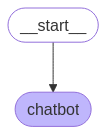

In [185]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

Now that the graph is defined, you can run it. It only has one node, and one transition into that node, so it will transition from `__start__` to `chatbot`, execute the `chatbot` node, and terminate.

To run the graph, you call `invoke` and pass an initial state object. In this case it begins with the user's initial message.

In [186]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: I can help you with your orders! I can look up your order history, track your orders, and process returns or cancellations. To get started, could you please provide your email address?


You could execute this in a Python loop, but for simplicity, manually invoke one more conversational turn. This second invocation takes the state from the first call and appends another user message to elicit another response from the chatbot.

In [187]:
user_msg = "I would like to lookup my orders using my email roshantiwary@apple.com?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: I can help you with your orders! I can look up your order history, track your orders, and process returns or cancellations. To get started, could you please provide your email address?
HumanMessage: I would like to lookup my orders using my email roshantiwary@apple.com?
AIMessage: ```tool_code
# First, list the tables to ensure the table name is correct.
print(tool_code.list_tables())
```


## Add a human node

Instead of repeatedly running the "graph" in a Python loop, you can use LangGraph to loop between nodes.

The `human` node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python `print` and `input` functions, but for a real cafe situation, you could render the chat to a display or audio, and accept input from a mic or on-screen keyboard.

The `chatbot` node function has also been updated to include the welcome message to start the conversation.

In [188]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderGenieState) -> OrderGenieState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderGenieState) -> OrderGenieState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([ORDERGENIE_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderGenieState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

Before you can run this, note that if you added an edge from `human` back to `chatbot`, the graph will cycle forever as there is no exit condition. One way to break the cycle is to add a check for a human input like `q` or `quit` and use that to break the loop.

In LangGraph, this is achieved with a conditional edge. This is similar to a regular graph transition, except a custom function is called to determine which edge to traverse.

Conditional edge functions take the state as input, and return a string representing the name of the node to which it will transition.

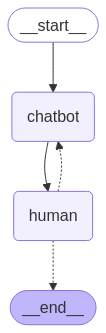

In [189]:
from typing import Literal


def maybe_exit_human_node(state: OrderGenieState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

Run this new graph to see how the interaction loop is now captured within the graph. Input `quit` to exit the program.
**You must uncomment the `.invoke(...)` line to run this step.**

In [190]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
#state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no order lookup or order modifications yet.
#  - 'q' to exit.

# pprint(state)

Now add the new tool to the graph. The `get_menu` tool is wrapped in a [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) that handles calling the tool and passing the response as a message through the graph. The tools are also bound to the `llm` object so that the underlying model knows they exist. As you now have a different `llm` object to invoke, you need to update the `chatbot` node so that it is aware of the tools.

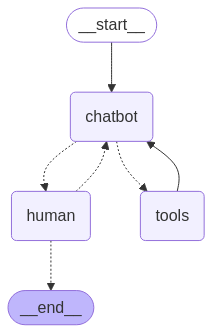

In [191]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [list_tables, describe_table, execute_query]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderGenieState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

def chatbot_with_tools(state: OrderGenieState) -> OrderGenieState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        # Debugging output to show message contents
        # print("\n== Debugging Messages Before API Call ==")
        # for msg in state["messages"]:
        #     print(msg.content)
        # Ensure that message contents are not empty
        if any(not msg.content.strip() for msg in state["messages"]):
            print("Detected empty message content.")
        new_output = llm_with_tools.invoke([ORDERGENIE_SYSINT] + state["messages"])
        try:
            new_output = llm_with_tools.invoke([ORDERGENIE_SYSINT] + state["messages"])
        except ChatGoogleGenerativeAIError as e:
            print(f"API call failed: {e}")
            new_output = AIMessage(content="I'm having trouble processing your request, could you please rephrase or try again?")
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {"messages": [new_output]}

graph_builder = StateGraph(OrderGenieState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

Now run the new graph to see how the model uses the menu.

**You must uncomment the `.invoke(...)` line to run this step.**

In [192]:
# Remember that you have not implemented ordering yet, so this will loop forever,
# unless you input `q`, `quit` or one of the other exit terms defined in the
# `human_node`.
# Uncomment this line to execute the graph:
# state = graph_with_menu.invoke({"messages": []}, config)

# Things to try:
# - Where is my order?
# - Need my purchase History?
# - Can I return my order?
# - Can I cancel my order?
# - 'q' to exit.


pprint(state)

Model: Welcome to the OrderGenie. Type `q` to quit. How may I help you today?


User:  what can you do?


Model: I can help you with your orders. I can look up your order history, check the status of your orders, and process returns or cancellations. To get started, please provide your email address.


User:  what is my purchase history?


Model: To access your purchase history, I need your email address. Could you please provide it?


User:  roger@tiger.com


 - DB CALL: describe_table(ORDER_ITEM_FULFILLMENT_RECORD)
Detected empty message content.
 - DB CALL: execute_query(SELECT * FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE EMAIL_ID = 'roger@tiger.com')
Detected empty message content.
Model: OK. I found order ORD001 placed on 2023-09-15. It includes 2 units of product SKU12345. The current status is 'SHIPPED'. Is there anything else I can help you with?


User:  I need to look up order using a new email


Detected empty message content.
Model: Sure, please provide the new email address you would like to use.


User:  'tim@horton.com'


Detected empty message content.
 - DB CALL: execute_query(SELECT * FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE EMAIL_ID = 'tim@horton.com')
No data found for the query, check parameters for grounding.
Detected empty message content.
Model: I couldn't find any orders associated with the email address tim@horton.com. Could you please double-check the email or provide another one?


User:  tim@horton.com


Detected empty message content.
Model: I checked again, but I still couldn't find any orders associated with tim@horton.com. Are you sure this is the correct email address? If so, it's possible you haven't placed any orders with us yet using this email.


User:  john@apple.com


Detected empty message content.
 - DB CALL: execute_query(SELECT * FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE EMAIL_ID = 'john@apple.com')
Detected empty message content.
Model: OK. I found an order with Order ID: ORD004, placed on 2023-09-18. The product SKU is SKU98765 with a quantity of 4. The current status is 'ORDERED'. What would you like to do next?


User:  Can I return the order ORD004?


Detected empty message content.
 - DB CALL: execute_query(SELECT EVENT_TYPE FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE ORDER_ID = 'ORD004' AND EMAIL_ID = 'john@apple.com')
Detected empty message content.
Model: To process a return, the item needs to be in 'Shipped' or 'PickedUp' status. The current status of order ORD004 is 'ORDERED'. You can only return items that have already been shipped or picked up.


User:  can I cancel this order?


Detected empty message content.
Model: Order ORD004 contains 4 units of SKU98765 with status 'ORDERED'. Would you like to proceed with the cancellation of all 4 items?


User:  1


Detected empty message content.
 - DB CALL: execute_query(SELECT EVENT_TYPE FROM ORDER_ITEM_FULFILLMENT_RECORD WHERE ORDER_ID = 'ORD004' AND EMAIL_ID = 'john@apple.com' AND PRODUCT_SKU = 'SKU98765')
Detected empty message content.
Model: You would like to cancel 1 unit of SKU98765 from order ORD004. The current status is 'ORDERED'. Do you confirm the cancellation of 1 item?


User:  q


{'finished': True,
 'messages': [AIMessage(content='Welcome to the OrderGenie. Type `q` to quit. How may I help you today?', additional_kwargs={}, response_metadata={}, id='34175115-8c8d-482b-b038-510701ae9ff1'),
              HumanMessage(content='what can you do?', additional_kwargs={}, response_metadata={}, id='1b4473b8-b530-4d93-adc5-ef0dae3c3b56'),
              AIMessage(content='I can help you with your orders. I can look up your order history, check the status of your orders, and process returns or cancellations. To get started, please provide your email address.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-b5b8b49c-938b-4213-b2a6-be3bbf179e36-0', usage_metadata={'input_tokens': 690, 'output_tokens': 40, 'total_tokens': 730, 'input_token_details': {'cache_read': 0}}),
              HumanMessage(content='what is my purchase history

Now define the graph. The LLM needs to know about the tools too, so that it can invoke them. Here you set up 2 sets of tools corresponding to the nodes under which they operate: automated and ordering.